# 1. Imports
- 데이터 분석과 시각화를 위한 라이브러리 불러오기
- 경고 메시지 무시, 한글 폰트 설정

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')


plt.rc('font', family='Apple SD Gothic Neo')

from pathlib import Path



# 2. Data 불러오기

In [61]:
DATA_DIR = Path('data')
if not DATA_DIR.exists():
    DATA_DIR = Path('../Data')

station_df = pd.read_csv(DATA_DIR / 'station_data.csv', index_col=0)
break_df = pd.read_excel(DATA_DIR / '서울시 공공자전거 고장신고 내역_23.1-6.xlsx', engine='openpyxl')
office_df = pd.read_excel(DATA_DIR / '서울특별시 공공자전거 대여소별 이용정보(월별)_23.1-6.xlsx', engine='openpyxl')
history_df = pd.read_csv(DATA_DIR / '서울특별시 공공자전거 대여이력 정보_2301.csv', encoding='cp949')

history_df['반납대여소번호'] = history_df['반납대여소번호'].replace('\\N', np.nan)
history_df['반납대여소번호'] = history_df['반납대여소번호'].astype(float)
office_df['대여건수'] = (office_df['대여건수'].astype(str).str.replace(',', '', regex=False))
office_df['대여건수'] = pd.to_numeric(office_df['대여건수'], errors='coerce').fillna(0).astype(int)
office_df['반납건수'] = (office_df['반납건수'].astype(str).str.replace(',', '', regex=False).replace(' - ', '0'))
office_df['반납건수'] = pd.to_numeric(office_df['반납건수'], errors='coerce').fillna(0).astype(int)


# 3. 프로모션 계획 (반납과 대여의 차이가 큰 곳에 프로모션 계획)
## 상황
특정 대여소에서는 자전거 과다, 특정 대여소에서는 자전거 부족
## 해결
과다한 곳에서 대여 & 부족한 곳에 반납시 프로모션(할인권, 포인트) 제공

즉, 자전거가 과다한 곳과 부족한 곳을 찾아야한다.

- 시간대별 과다율 확인하기위해 일시를 datetime으로 변경

In [62]:
history_df['대여시간'] = pd.to_datetime(history_df['대여일시']).dt.hour
history_df['반납시간'] = pd.to_datetime(history_df['반납일시']).dt.hour

history_df.head()

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),생년,성별,이용자종류,대여대여소ID,반납대여소ID,대여시간,반납시간
0,SPB-39194,2023-01-01 00:02:13,1554,번동사거리,0,2023-01-01 00:02:43,1554.0,번동사거리,0,0,0.0,1977,\N,내국인,ST-2127,ST-2127,0,0
1,SPB-43457,2023-01-01 00:01:20,1653,노원역1번출구,0,2023-01-01 00:03:28,4003.0,상계초교 입구 교차로 명주빌딩 앞,0,2,0.0,1998,\N,내국인,ST-1121,ST-2699,0,0
2,SPB-44383,2023-01-01 00:04:01,2601,석촌호수 아뜰리에,0,2023-01-01 00:04:21,2601.0,석촌호수 아뜰리에,0,0,0.0,1993,M,내국인,ST-1590,ST-1590,0,0
3,SPB-37186,2023-01-01 00:02:09,1080,엘웨딩,0,2023-01-01 00:04:59,3668.0,성내삼성아파트,0,2,0.0,1965,M,내국인,ST-1841,ST-2740,0,0
4,SPB-59440,2023-01-01 00:02:24,1351,안암2교 옆,0,2023-01-01 00:05:02,1308.0,안암로터리 버스정류장 앞,0,2,780.0,1986,M,내국인,ST-1215,ST-827,0,0


### 반납, 대여 대여소당 대여시간 별 대여횟수

In [63]:
rental_counts = history_df.groupby(['대여 대여소명','대여시간']).size().reset_index(name='대여횟수')
return_counts = history_df.groupby(['반납대여소명','반납시간']).size().reset_index(name='반납횟수')

In [64]:
rental_counts.head()

,대여 대여소명,대여시간,대여횟수
0,(시립)고덕평생학습관,0,1
1,(시립)고덕평생학습관,1,2
2,(시립)고덕평생학습관,2,3
3,(시립)고덕평생학습관,3,4
4,(시립)고덕평생학습관,4,1


In [65]:
return_counts.head()

,반납대여소명,반납시간,반납횟수
0,(시립)고덕평생학습관,0,3
1,(시립)고덕평생학습관,1,2
2,(시립)고덕평생학습관,2,5
3,(시립)고덕평생학습관,3,5
4,(시립)고덕평생학습관,4,1


같은 대여소당 대여횟수, 반납횟수를 나란히 보기 위해 두 프레임 merge

In [66]:
merged_counts = pd.merge(rental_counts, return_counts, left_on = ['대여 대여소명','대여시간'],
                        right_on=['반납대여소명','반납시간'],how='outer').fillna(0)
merged_counts.head()

,대여 대여소명,대여시간,대여횟수,반납대여소명,반납시간,반납횟수
0,(시립)고덕평생학습관,0.0,1.0,(시립)고덕평생학습관,0.0,3.0
1,(시립)고덕평생학습관,1.0,2.0,(시립)고덕평생학습관,1.0,2.0
2,(시립)고덕평생학습관,2.0,3.0,(시립)고덕평생학습관,2.0,5.0
3,(시립)고덕평생학습관,3.0,4.0,(시립)고덕평생학습관,3.0,5.0
4,(시립)고덕평생학습관,4.0,1.0,(시립)고덕평생학습관,4.0,1.0


- 대여 대여소명 = 반납대여소명 , 대여시간 = 반납시간 이기때문에 반납 * 은 drop
- 대여 반납 구분짓지않도록 대여 대여소명 -> 대여소명, 대여시간 -> 시간 으로 변경

In [67]:
merged_counts = merged_counts.drop(columns=['반납대여소명','반납시간'])
merged_counts = merged_counts.rename(columns={'대여 대여소명' : '대여소명', "대여시간":"시간"})

In [68]:
merged_counts.head()

,대여소명,시간,대여횟수,반납횟수
0,(시립)고덕평생학습관,0.0,1.0,3.0
1,(시립)고덕평생학습관,1.0,2.0,2.0
2,(시립)고덕평생학습관,2.0,3.0,5.0
3,(시립)고덕평생학습관,3.0,4.0,5.0
4,(시립)고덕평생학습관,4.0,1.0,1.0


### 각 대여소별 대여횟수와 반납횟수를 비교하여 대여가 더 많은지 반납이 더 많은지 확인
- 대여 - 반납 -> 음수면 반납이 더 많고, 양수면 대여가 더 많음
- 음수인 곳에서 대여시 프로모션, 양수인 곳에서 반납시 프로모션 제공

In [69]:
merged_counts['대여-반납'] = merged_counts['대여횟수'] - merged_counts['반납횟수']
merged_counts.head()

,대여소명,시간,대여횟수,반납횟수,대여-반납
0,(시립)고덕평생학습관,0.0,1.0,3.0,-2.0
1,(시립)고덕평생학습관,1.0,2.0,2.0,0.0
2,(시립)고덕평생학습관,2.0,3.0,5.0,-2.0
3,(시립)고덕평생학습관,3.0,4.0,5.0,-1.0
4,(시립)고덕평생학습관,4.0,1.0,1.0,0.0


In [70]:
merged_counts.sort_values('대여-반납').head() # 반납이 많은 순

,대여소명,시간,대여횟수,반납횟수,대여-반납
55323,코오롱One&Only타워,8.0,32.0,777.0,-745.0
1436,LG유플러스 마곡사옥,8.0,55.0,756.0,-701.0
19317,마곡문화공원,8.0,64.0,759.0,-695.0
41329,"양천구청, 보건소 사잇길",8.0,59.0,733.0,-674.0
19237,마곡나루역 3번 출구,17.0,275.0,862.0,-587.0


In [71]:
merged_counts.sort_values('대여-반납', ascending=False).head() # 대여가 많은 순

,대여소명,시간,대여횟수,반납횟수,대여-반납
19251,마곡나루역 5번출구 뒤편,8.0,1491.0,939.0,552.0
1445,LG유플러스 마곡사옥,17.0,653.0,120.0,533.0
55332,코오롱One&Only타워,17.0,531.0,43.0,488.0
41339,"양천구청, 보건소 사잇길",18.0,690.0,208.0,482.0
19063,마곡13단지,8.0,460.0,67.0,393.0


# 4. 대여소 추가 설치 계획
### Clustering 이란?
- 머신러닝 기법 중 비지도 학습, 비슷한 특성을 가진 데이터 포인트들을 같은 그룹으로 묶는 기법
- 정확한 정보가 없이도 패턴을 찾아낼 수 있음
### NMeans 란?
- 주어진 데이터를 비슷한 특성의 k개의 클러스터로 분류
- `n_clusters`:클러스터의 개수 설정

In [72]:
from sklearn.cluster import KMeans

In [73]:
kmeans = KMeans(n_clusters=250, random_state=13) # 250개의 클러스터와 13 난수 시드 사용
station_df['cluster'] = kmeans.fit_predict(station_df[['stationLatitude', 'stationLongitude']])
station_df.head()

,rackTotCnt,stationName,parkingBikeTotCnt,shared,stationLatitude,stationLongitude,stationId,cluster
0,15,102. 망원역 1번출구 앞,21,140,37.555649,126.910629,ST-4,110
1,14,103. 망원역 2번출구 앞,24,171,37.554951,126.910835,ST-5,110
2,13,104. 합정역 1번출구 앞,4,31,37.550739,126.915085,ST-6,110
3,5,105. 합정역 5번출구 앞,0,0,37.550007,126.914825,ST-7,110
4,12,106. 합정역 7번출구 앞,7,58,37.548645,126.912827,ST-8,110


- rackTotCnt : 거치대 수

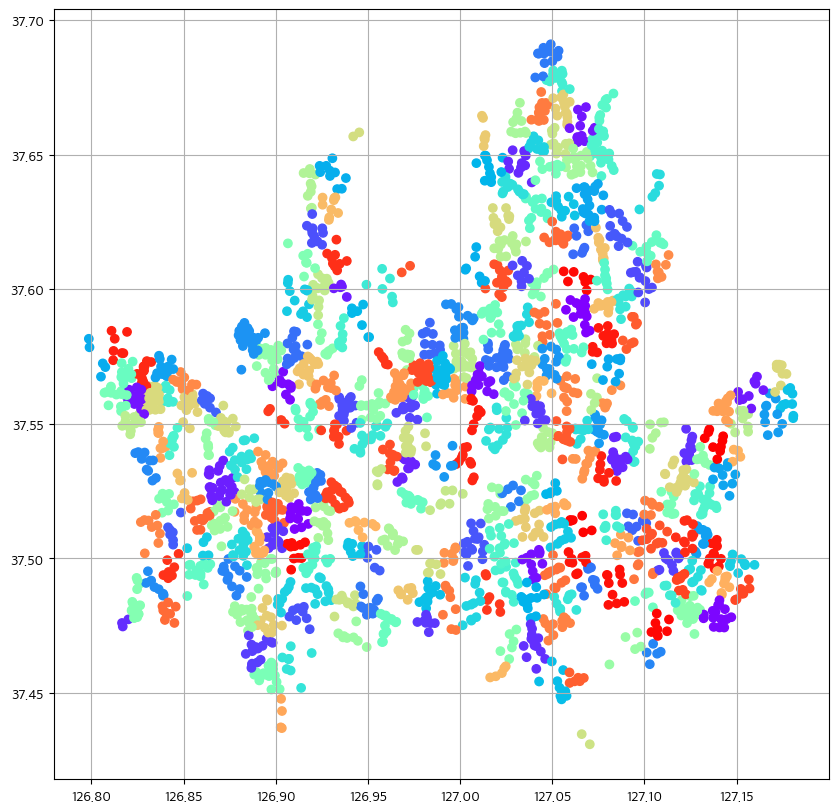

In [74]:
plt.figure(figsize = (10,10))
plt.scatter(station_df['stationLongitude'], station_df['stationLatitude'], c=station_df['cluster'],cmap='rainbow')
plt.grid(True)
plt.show()

In [75]:
merged_data = pd.merge(office_df,station_df, left_on='대여소명',right_on='stationName',how='inner')
merged_data.head()

,자치구,대여소명,기준년월,대여건수,반납건수,rackTotCnt,stationName,parkingBikeTotCnt,shared,stationLatitude,stationLongitude,stationId,cluster
0,강남구,2301. 현대고등학교 건너편,202301,383,439,10,2301. 현대고등학교 건너편,15,150,37.524071,127.02179,ST-777,138
1,강남구,2301. 현대고등학교 건너편,202302,876,978,10,2301. 현대고등학교 건너편,15,150,37.524071,127.02179,ST-777,138
2,강남구,2301. 현대고등학교 건너편,202303,2258,2364,10,2301. 현대고등학교 건너편,15,150,37.524071,127.02179,ST-777,138
3,강남구,2301. 현대고등학교 건너편,202304,2766,2666,10,2301. 현대고등학교 건너편,15,150,37.524071,127.02179,ST-777,138
4,강남구,2301. 현대고등학교 건너편,202305,3233,3373,10,2301. 현대고등학교 건너편,15,150,37.524071,127.02179,ST-777,138


In [76]:
cluster_summary = merged_data.groupby('cluster').agg({
    'rackTotCnt':'sum',            # 거치대 수
    '대여건수'   :'sum',            # 6월간의 대여 건수
    '반납건수'   :'sum'       ,      # 6개월 간의 반남 건수
    '대여소명':pd.Series.nunique # 대여소 개수
})
cluster_summary.head()

,rackTotCnt,대여건수,반납건수,대여소명
cluster,,,,
0,920,104346,104049,12
1,746,122864,122993,12
2,738,59728,58416,12
3,708,80932,78500,8
4,1236,130654,127866,13


In [77]:
cluster_summary['거치대 대비 대여율'] = cluster_summary['대여건수']/cluster_summary['rackTotCnt']
cluster_summary['거치대 대비 반납율'] = cluster_summary['반납건수']/cluster_summary['rackTotCnt']
cluster_summary['대여소 대비 대여율'] = cluster_summary['대여건수']/cluster_summary['대여소명']
cluster_summary['대여소 대비 반납율'] = cluster_summary['반납건수']/cluster_summary['대여소명']
cluster_summary.head()


,rackTotCnt,대여건수,반납건수,대여소명,거치대 대비 대여율,거치대 대비 반납율,대여소 대비 대여율,대여소 대비 반납율
cluster,,,,,,,,
0,920,104346,104049,12,113.419565,113.096739,8695.500000,8670.750000
1,746,122864,122993,12,164.697051,164.869973,10238.666667,10249.416667
2,738,59728,58416,12,80.932249,79.154472,4977.333333,4868.000000
3,708,80932,78500,8,114.310734,110.875706,10116.500000,9812.500000
4,1236,130654,127866,13,105.707120,103.451456,10050.307692,9835.846154


In [78]:
cluster_summary.sort_values('거치대 대비 대여율', ascending=False).head()

,rackTotCnt,대여건수,반납건수,대여소명,거치대 대비 대여율,거치대 대비 반납율,대여소 대비 대여율,대여소 대비 반납율
cluster,,,,,,,,
95,450,142331,141585,7,316.291111,314.633333,20333.000000,20226.428571
201,306,86411,85888,6,282.388889,280.679739,14401.833333,14314.666667
222,798,221886,224499,11,278.052632,281.327068,20171.454545,20409.000000
230,324,89421,94476,4,275.990741,291.592593,22355.250000,23619.000000
33,642,175545,174638,8,273.434579,272.021807,21943.125000,21829.750000


In [79]:
cluster_summary.sort_values('거치대 대비 반납율', ascending=False).head()

,rackTotCnt,대여건수,반납건수,대여소명,거치대 대비 대여율,거치대 대비 반납율,대여소 대비 대여율,대여소 대비 반납율
cluster,,,,,,,,
95,450,142331,141585,7,316.291111,314.633333,20333.000000,20226.428571
230,324,89421,94476,4,275.990741,291.592593,22355.250000,23619.000000
222,798,221886,224499,11,278.052632,281.327068,20171.454545,20409.000000
201,306,86411,85888,6,282.388889,280.679739,14401.833333,14314.666667
33,642,175545,174638,8,273.434579,272.021807,21943.125000,21829.750000


In [80]:
station_df[station_df['cluster']==249]

,rackTotCnt,stationName,parkingBikeTotCnt,shared,stationLatitude,stationLongitude,stationId,cluster
670,15,1044. 굽은다리역,2,13,37.545406,127.142677,ST-1061,249
680,6,1060. 천일초교 사거리,3,50,37.544670,127.132675,ST-1620,249
681,8,1061. 천호초교 입구 사거리(일주빌딩),0,0,37.546898,127.134666,ST-1621,249
690,7,1073. SSTS 몰 앞,0,0,37.541145,127.141052,ST-1834,249
692,10,1075.천동초교 삼거리,2,20,37.541363,127.137184,ST-1836,249
693,10,1076. 천동초교입구사거리 버스정류장(십자성마을 방면),9,90,37.539894,127.141037,ST-1837,249
1890,10,3681. 길동 마루빌딩,8,80,37.536854,127.139488,ST-2749,249
1891,10,3682. 길동 동호빌딩,1,10,37.541546,127.141479,ST-2750,249
1892,10,3683. KT&G강동지사,4,40,37.543709,127.142281,ST-2751,249
2532,5,4951. 강동농협 버스정류소 앞(광채빌라),1,20,37.547966,127.135162,ST-3147,249


In [81]:
cluster_summary.sort_values('대여소 대비 대여율', ascending=False).head()

,rackTotCnt,대여건수,반납건수,대여소명,거치대 대비 대여율,거치대 대비 반납율,대여소 대비 대여율,대여소 대비 반납율
cluster,,,,,,,,
230,324,89421,94476,4,275.990741,291.592593,22355.250000,23619.000000
33,642,175545,174638,8,273.434579,272.021807,21943.125000,21829.750000
236,1314,185509,185924,9,141.178843,141.494673,20612.111111,20658.222222
95,450,142331,141585,7,316.291111,314.633333,20333.000000,20226.428571
222,798,221886,224499,11,278.052632,281.327068,20171.454545,20409.000000


In [82]:
cluster_summary.sort_values('대여소 대비 반납율', ascending=False).head()

,rackTotCnt,대여건수,반납건수,대여소명,거치대 대비 대여율,거치대 대비 반납율,대여소 대비 대여율,대여소 대비 반납율
cluster,,,,,,,,
230,324,89421,94476,4,275.990741,291.592593,22355.250000,23619.000000
33,642,175545,174638,8,273.434579,272.021807,21943.125000,21829.750000
236,1314,185509,185924,9,141.178843,141.494673,20612.111111,20658.222222
222,798,221886,224499,11,278.052632,281.327068,20171.454545,20409.000000
172,882,218895,222861,11,248.180272,252.676871,19899.545455,20260.090909


In [83]:
station_df[station_df['cluster']==222]

,rackTotCnt,stationName,parkingBikeTotCnt,shared,stationLatitude,stationLongitude,stationId,cluster
821,10,1251. 석촌역 2번출구,6,60,37.505932,127.107750,ST-1070,222
828,10,1262. 송파여성문화회관 앞,0,0,37.505802,127.109718,ST-1081,222
852,10,1296. 석촌호수교차로 (송파나루근린공원 앞),1,10,37.508678,127.103432,ST-1585,222
853,15,1297. 석촌호수교차로(동호 팔각정 앞),5,33,37.509201,127.104118,ST-1586,222
1575,16,2601. 석촌호수 아뜰리에,1,6,37.506748,127.098831,ST-1590,222
1589,12,2620. 송파나루역 4번 출구옆,0,0,37.509979,127.112312,ST-1730,222
1592,15,2623.석촌동 주민센터,1,7,37.503624,127.103554,ST-1851,222
1604,18,2639.석촌역 8번출구,6,33,37.505505,127.106575,ST-1866,222
1611,7,2647.잠실 자전거 수리센터 앞,22,314,37.511009,127.101143,ST-1868,222
2477,10,4868. 석촌호수 서호 남단,1,10,37.507172,127.101242,ST-2833,222


# 5. 고장예측

## 상황
따릉이 어플리케이션에는 고장신고 기능이있지만, 사용자는 큰 고장이 아니면 적극적으로 이용해서 조치를 취하지 않는다. 고장난 자전거는 사용자 경험에 불편을 가져오기 때문에 빠르게 조치하고 싶다.

## 해결법
고장난 자적거의 고장신고 직전 대여에서 특이점을 찾는다.

## 가설
- 고장날 자전거는 이용에 불편함을 줄것이고 긴 시간 이용을 하지 않을 것이다.
- 고장 때문에 불편한 자전거는 빠르게 반납하는 횟수가 잦을 것이다.

In [84]:
# 일자 데이터 date타입으로 가져오기
break_df['등록일시'] = pd.to_datetime(break_df['등록일시'])
history_df['대여일시'] = pd.to_datetime(history_df['대여일시'])

In [85]:
# history_df에는 1월 데이터만 있으니 break_df에서 1월 데이터만 가져오기
jan_break_df = break_df[
    (break_df['등록일시'] >= '2023-01-01') & (break_df['등록일시'] < '2023-02-01')
]
jan_break_df


,자전거번호,등록일시,구분
0,SPB-62819,2023-01-01 00:01:00,안장
1,SPB-62819,2023-01-01 00:01:00,페달
2,SPB-32382,2023-01-01 00:24:00,타이어
3,SPB-81126,2023-01-01 01:20:00,단말기
4,SPB-45763,2023-01-01 01:49:00,체인
...,...,...,...
8681,SPB-42257,2023-01-31 22:50:00,체인
8682,SPB-54335,2023-01-31 22:56:00,기타
8683,SPB-41014,2023-01-31 23:17:00,안장
8684,SPB-59701,2023-01-31 23:29:00,체인


### 자전거 고장 직전 대여 이력 추가 (`break_soon`)
---
#### 1. 컬럼 초기화
- `history_df['break_soon'] = False`
  → 모든 대여 이력에 `break_soon` 컬럼을 만들어 초기값을 `False`로 설정

---

#### 2. 고장 데이터 복사
- `jan_break_df` (1월 고장신고 내역)을 복사해 사용
- while 루프로 돌면서 데이터가 소진될 때까지 반복 처리

---

#### 3. 자전거별 중복 제거
- `drop_duplicates('자전거번호')`
  → 복사본에서 같은 자전거번호가 여러 번 신고된 경우 **맨 앞의 1건만** 남김
- 이렇게 하면 한 사이클에 자전거당 1건씩만 처리

---

#### 4. 이력 데이터와 병합
- `history_df.merge(..., on='자전거번호', how='left')`
  → 자전거 번호 기준으로 이력(`history_df`)과 신고내역(`unique_copied_jan_break_df`)을 합침
- 이로써 각 대여 이력에 해당 자전거의 신고일시(`등록일시`)가 매칭됨

---

#### 5. 조건 계산 (`break_soon` 여부)
- 조건식:
  ```python
  (대여일시 > 등록일시 - 2일) & (대여일시 < 등록일시)

In [86]:
import datetime

In [87]:
history_df['break_soon'] = False # braek_soon  초기화

copied_jan_break_df = jan_break_df.copy() # 1월 데이터 복사
while len(copied_jan_break_df) != 0 : # 0이되면 멈춤
    unique_copied_jan_break_df = copied_jan_break_df.drop_duplicates('자전거번호') # 복사본에서 자전거번호별 한행씩만 남김 -> 등록일시가 다르면서 같은 자전거번호 정리

    merged_df = history_df.merge(unique_copied_jan_break_df[['자전거번호', '등록일시']], on='자전거번호', how='left') # 자전거 번호로 merge
    # how='left' -> history_df와 merged_df가 같은 인덱스를 같게 하기위해

    merged_df['break_soon'] = (
        (merged_df['대여일시'] > merged_df['등록일시'] - datetime.timedelta(days=2)) &
        (merged_df['대여일시'] < merged_df['등록일시'])
        ) # True, False 데이터 쌓임

    history_df.loc[merged_df['break_soon'], "break_soon"] = True
    copied_jan_break_df.drop(index=unique_copied_jan_break_df.index, inplace=True) # 복사본에서 해당루프에서 사용한 행 삭제(이거안하면 무한루프)

In [88]:
sum(history_df['break_soon']) # 데이터 건수 확인

55747

In [89]:
history_df[history_df['break_soon']].head()

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),생년,성별,이용자종류,대여대여소ID,반납대여소ID,대여시간,반납시간,break_soon
0,SPB-39194,2023-01-01 00:02:13,1554,번동사거리,0,2023-01-01 00:02:43,1554.0,번동사거리,0,0,0.0,1977,\N,내국인,ST-2127,ST-2127,0,0,True
47,SPB-53361,2023-01-01 00:09:41,1630,수연빌딩 앞,0,2023-01-01 00:10:22,1630.0,수연빌딩 앞,0,0,0.0,2001,\N,내국인,ST-869,ST-869,0,0,True
92,SPB-33396,2023-01-01 00:13:19,328,탑골공원 앞,0,2023-01-01 00:13:59,328.0,탑골공원 앞,0,0,0.0,1988,M,내국인,ST-144,ST-144,0,0,True
168,SPB-53550,2023-01-01 00:18:46,1185,등촌9단지,0,2023-01-01 00:18:54,1185.0,등촌9단지,0,0,0.0,1996,\N,내국인,ST-1646,ST-1646,0,0,True
241,SPB-59141,2023-01-01 00:18:01,1149,신방화역환승주차장,0,2023-01-01 00:23:20,1162.0,공항초등학교건너편,0,5,630.0,2002,\N,내국인,ST-975,ST-1253,0,0,True


고장 예정인 자전거의 이용시간은 더 짧을 것이라고 예상

In [90]:
history_df[history_df['break_soon']]['이용시간(분)'].mean()

14.473101691570847

In [91]:
history_df[~history_df['break_soon']]['이용시간(분)'].mean()

17.70024730211558

고장 예정인 자전거의 0분이용 비율이 더 클 것이라고 예상

In [92]:
sum((history_df['break_soon']) & (history_df['이용시간(분)'] == 0)) / sum(history_df['break_soon'])

0.10596085888029849

In [93]:
sum((~history_df['break_soon']) & (history_df['이용시간(분)'] == 0)) / sum(~history_df['break_soon'])

0.03255627594789122

### 고장 예정 자전거 이용 특성 분석
---
## 1. 분석 목적
- 자전거가 고장으로 신고되기 **며칠 전부터** 이상 징후가 나타나는지 확인
- 고장 직전 대여 이력(`break_soon=True`)과 정상 대여 이력(`break_soon=False`)을 비교
---
## 2. 분석 방법
- 반복문(`for days in range(1, 10)`)을 통해 **1일 전 ~ 9일 전**까지 범위를 점차 확장
- 각 범위별로:
  1. `break_soon` 플래그 초기화
  2. (앞서 작성한 while문 로직을 통해) 고장 신고일 기준 `days`일 전 대여 이력에 플래그 부여
  3. `break_soon=True` / `False` 그룹으로 나눠 지표 계산
---
## 3. 비교 지표
- **평균 이용시간**
  - 고장 예정 자전거 vs 정상 자전거의 평균 이용시간 차이
- **0분 이용 비율**
  - 고장 예정 자전거 대여 중 실제로 사용되지 않은(=이용시간 0분) 비율
  - 정상 자전거와 비교해 상대적으로 높아지는지 확인

In [95]:
for days in range(1, 10):   # 1일부터 9일까지 반복 (고장 신고일 기준 며칠 전 데이터인지 확인하기 위함)
    history_df['break_soon'] = False   # 매 반복마다 break_soon 플래그 초기화

    copied_jan_break_df = jan_break_df.copy()  # 1월 고장신고 내역 복사본 준비
    while len(copied_jan_break_df) != 0:       # 복사본이 빌 때까지 반복 (자전거별 신고내역 모두 소진할 때까지)
        # 자전거번호별로 중복 제거 → 한 라운드에서는 자전거당 1건만 처리
        unique_copied_jan_break_df = copied_jan_break_df.drop_duplicates('자전거번호')

        # 대여이력(history_df)에 이번 라운드 신고내역(등록일시) 병합
        merged_df = history_df.merge(
            unique_copied_jan_break_df[['자전거번호', '등록일시']],
            on='자전거번호', how='left'
        )

        # break_soon 조건 설정
        # "등록일시 기준 (days일 전) ~ (days-1일 전) 사이의 대여일시" → 특정 날짜 구간만 True
        merged_df['break_soon'] = (
            (merged_df['대여일시'] > merged_df['등록일시'] - datetime.timedelta(days=days)) &
            (merged_df['대여일시'] < merged_df['등록일시'] - datetime.timedelta(days=days-1))
        )

        # 조건에 맞는 행을 history_df에 반영 (merged_df['break_soon']가 True 면 break_soon = True로 업데이트)
        history_df.loc[merged_df['break_soon'], "break_soon"] = True

        # 이번 라운드에 사용한 신고내역은 복사본에서 삭제 → 다음 라운드에서 같은 자전거의 다음 신고내역 처리
        copied_jan_break_df.drop(index=unique_copied_jan_break_df.index, inplace=True)

    # 고장 예정 자전거 그룹의 평균 이용시간
    mean_break_soon = history_df[history_df['break_soon']]['이용시간(분)'].mean()
    # 그 외 자전거 그룹의 평균 이용시간
    mean_not_break_soon = history_df[~history_df['break_soon']]['이용시간(분)'].mean()

    # 고장 예정 그룹에서 "이용시간 0분" 비율
    zero_min_break_soon = sum((history_df['break_soon']) & (history_df['이용시간(분)'] == 0)) / sum(history_df['break_soon'])
    # 정상 그룹에서 "이용시간 0분" 비율
    zero_min_not_break_soon = sum((~history_df['break_soon']) & (history_df['이용시간(분)'] == 0)) / sum(~history_df['break_soon'])

    # 결과 출력 (소수점 3자리 반올림)
    print(f'{days}일 이전 / 고장 예정 자전거 이용시간 : {round(mean_break_soon, 3)},\
    그 외 자전거 이용시간 : {round(mean_not_break_soon, 3)}')

    print(f'{days}일 이전 / 고장 예정 0분 이용 비율 : {round(zero_min_break_soon, 3)},\
    그 외 0분 이용 비율 : {round(zero_min_not_break_soon, 3)}')

    print('------------------------------------------------------------------------------------------------')

1일 이전 / 고장 예정 자전거 이용시간 : 13.424,    그 외 자전거 이용시간 : 17.685
1일 이전 / 고장 예정 0분 이용 비율 : 0.125,    그 외 0분 이용 비율 : 0.033
------------------------------------------------------------------------------------------------
2일 이전 / 고장 예정 자전거 이용시간 : 16.333,    그 외 자전거 이용시간 : 17.606
2일 이전 / 고장 예정 0분 이용 비율 : 0.072,    그 외 0분 이용 비율 : 0.035
------------------------------------------------------------------------------------------------
3일 이전 / 고장 예정 자전거 이용시간 : 16.481,    그 외 자전거 이용시간 : 17.602
3일 이전 / 고장 예정 0분 이용 비율 : 0.058,    그 외 0분 이용 비율 : 0.035
------------------------------------------------------------------------------------------------
4일 이전 / 고장 예정 자전거 이용시간 : 17.128,    그 외 자전거 이용시간 : 17.595
4일 이전 / 고장 예정 0분 이용 비율 : 0.05,    그 외 0분 이용 비율 : 0.035
------------------------------------------------------------------------------------------------
5일 이전 / 고장 예정 자전거 이용시간 : 17.437,    그 외 자전거 이용시간 : 17.592
5일 이전 / 고장 예정 0분 이용 비율 : 0.041,    그 외 0분 이용 비율 : 0.035
-------------------------------------------